In [2]:
# -*- coding: utf-8 -*-

#!/usr/bin/python
# -*- coding: utf-8 -*-

In [3]:
__author__ = 'pnovais'

# Modelos de Rotatividade

Em um cenário onde obter clientes para uma dada empresa é cada vez mais complexo, os modelos de rotatividade tentam entender como e o porquê de clientes deixarem de usufruir de um dado produto ofertado pelas empresas. Entender a rotatividade dos clientes é uma ferramenta útil para fundamentar ações que visem melhorar a relação empresa-cliente. Esses modelos são bastante utilizados, por exemplo, por empresas de telefonia, de cartões de crédito, de serviços de streaming e outros.

Os modelos mais simples de rotatividade predizem uma taxa de rotatividade como, em um dado intervalo de tempo, sendo a razão entre os clientes que abandonaram um dado produto e os clientes que se mantiveram como consumidores do mesmo. 

Na presente análise, são utilizados dados de um banco que está buscando entender a rotatividade dos seus clientes.

***
# Dataset Churn

Dataset com informações sobre a rotatividade de clientes de um banco. 

***

In [4]:
#Importando as bibliotecas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
from termcolor import colored,cprint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import norm
import matplotlib.mlab as mlab

%matplotlib inline

In [5]:
ini=time.time()
plt.style.use('mystyle-paty.mplstyle')

# Breve reconhecimento do dataset

Abaixo, descrevemos as informações contidas no dataset **Churn**, bem como algumas estatísticas básicas tanto das variáveis contínuas quanto das variáveis categóricas.

### Informações contidas no dataset
O dataset apresenta diversas características dos clientes do banco, sendo que o significado de cada variável é descrito a seguir:

- RowNumber: numeração do dado no dataset (linha da planilha)
- CustomerId: número de identificação do cliente
- Surname: sobrenome
- CreditScore: pontuação de crédito
- Geography: localização
- Gender: genêro
- Age: idade 
- Tenure: período em que o cliente se manteve no banco
- Balance: saldo
- NumOfProducts: número de produtos contratados
- HasCrCard: se tem ou não cartão de crédito (1 - sim, 0 - não)
- IsActiveMember: se é um cliente ativo do banco (1 - sim, 0 - não)
- EstimatedSalary: salário estimado
- Exited: se saiu ou não do banco (1 - sim, 0 - não)


In [6]:
# Abrindo o dataset
df = pd.read_csv('Churn_Modelling.csv')

In [7]:
# Overview dos dados
text = colored(' >> O dataset possui informações sobre %d objetos' %len(df), 'green', attrs=['bold','underline'])
cprint(text)
df.head()

 >> O dataset possui informações sobre 10000 objetos


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


- Das 14 variáveis disponíveis, temos 6 variáveis variáveis categóricas nominais:Surname, Geography, Gender, HasCrCard, IsActiveMember e Exited. (ainda que os 3 últimos apareçam no dataset como variável inteira).

In [8]:
# Convertendo as variáveis inteiras para object
df['HasCrCard'] = df['HasCrCard'].astype('object')
df['IsActiveMember'] = df['IsActiveMember'].astype('object')
df['Exited'] = df['Exited'].astype('object')

In [9]:
df.describe(include=['O'])

,Surname,Geography,Gender,HasCrCard,IsActiveMember,Exited
count,10000,10000,10000,10000,10000,10000
unique,2932,3,2,2,2,2
top,Smith,France,Male,1,1,0
freq,32,5014,5457,7055,5151,7963


In [10]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,100090.239881
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,57510.492818
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,51002.110000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,100193.915000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,149388.247500
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000


- Apenas com a estatística básica dos dados já é possível inferir que:

- Cerca de 50% dos clientes estão entre 32 e 44 anos, ou seja, é predominantemente clientes financeiramente ativos
- A permanência máxima nos dados foi de 10 meses ?
- A quantidade máxima de produtos que um mesmo cliente possui e 4.

### Distribuições dos parâmetros


/home/pnovais/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


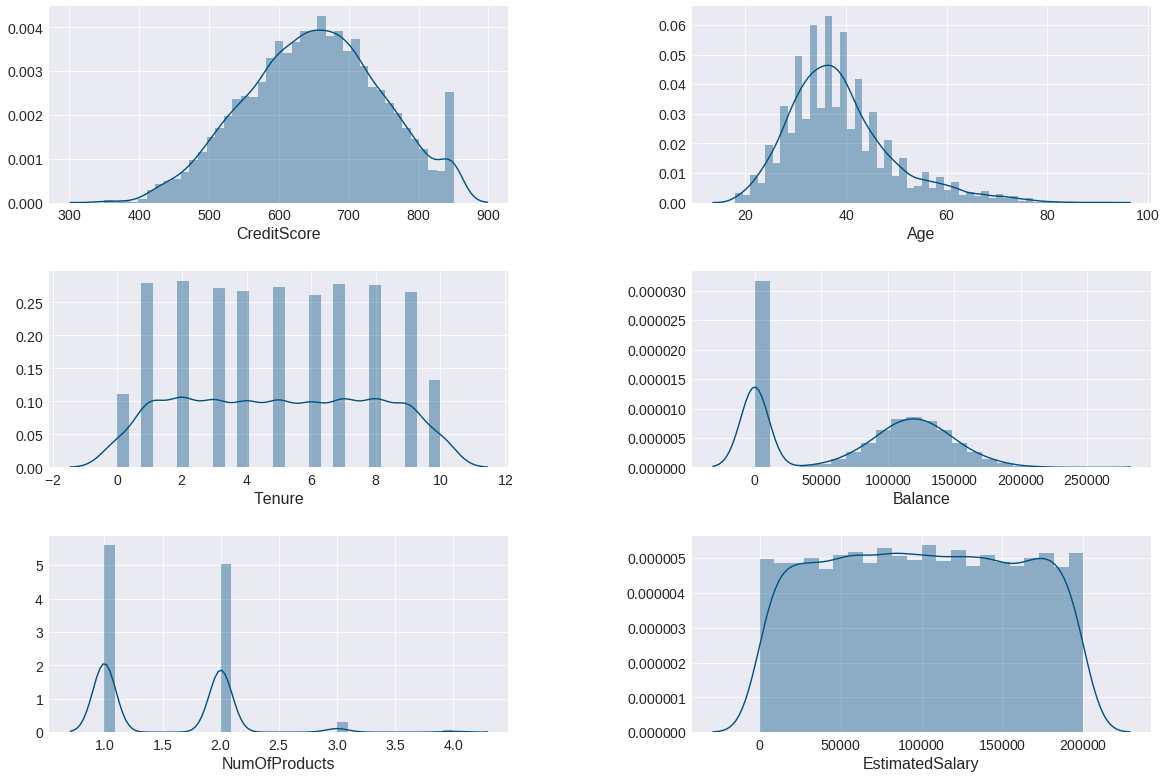

In [11]:
#Distribuição das variáveis quantitativas
features2 = ["CreditScore", "CreditScore", "Age", "Tenure", "Balance",
             "NumOfProducts", "EstimatedSalary"]
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))
for col, ax in zip(features2[1:], axs.ravel()):
    x=df.loc[:,col]
    sns.distplot(x, ax=ax)
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,
                    wspace=0.4)

- A distribuição do Score é quase gaussiano, com média em torno de 650
- A distribuição da idade também quase gaussiana, exceto pela asa direita que é mais alongada do que a esquerda. O valor médio de idade está em torno de 38 anos
- Há quase a mesma proporção de clientes em todos os valores de Tenure, exceto para Ternure = 0 e Ternure = 10
- Há uma quantidade considerável de clientes com saldo nulo, enquanto que a distribuição dos demais também parece ser gaussiana
- A maioria dos clientes possuem 1 ou 2 produtos do banco
- Os salários estimadores possuem quase a mesma quantidade de clientes por faixa estimada no histograma.

### Genêro

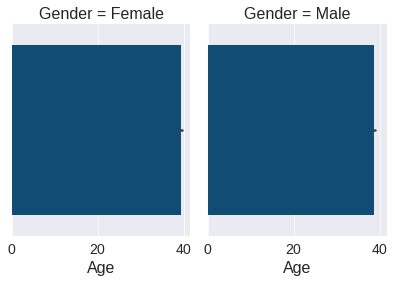

In [14]:
g = sns.factorplot(x="Age", col="Gender",
                    data=df, kind="bar",
                   size=4, aspect=.7);

In [ ]:
fim = time.time()
time_proc = fim - ini
print('')
#print(bcolors.FAIL +'-'*79+ bcolors.ENDC)
print('-------------------')
print('tempo de processamento: %fmin' %(time_proc/60))
print('-------------------')
today = datetime.datetime.now()
print('Hoje é %s/%s/%s, às %s:%s' %(today.day,today.month, today.year, today.hour, today.minute))